In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os, glob, inspect, sys
from sksurv.ensemble import RandomSurvivalForest
from sksurv.datasets import load_gbsg2
import sksurv
import eli5
from eli5.sklearn import PermutationImportance
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler

currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0,parentdir) 
import epri_mc_lib_3 as mc
from importlib import reload
reload(mc)


/home/nick/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.scorer module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)
/home/nick/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.feature_selection.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_selection. Anything that cannot be imported from sklearn.feature_selection is now part of the private API.
  warnings.warn(message, FutureWarning)
Using TensorFlow backend.


<module 'epri_mc_lib_3' from '/home/nick/Bureau/Programming/S2DS/Oct20_EPRI/Task3/NB/epri_mc_lib_3.py'>

In [2]:
data = pd.read_csv(os.path.join(os.path.dirname(os.getcwd()), '../Data/Merged_data/CopulaGAN_simulated_data_survival.csv'),
                  index_col=0)
data.reset_index(inplace=True)

## Format data

In [33]:
data_x = data.iloc[:, 2:]
data_y = data.iloc[:, 0:2]
data_y

,Observed,F_Time
0,False,1.751191e+06
1,False,8.805501e+05
2,True,3.848121e+05
3,True,1.194672e+06
4,True,7.445108e+05
...,...,...
995,False,3.035034e+06
996,True,6.093648e+05
997,True,3.989339e+05
998,True,3.731964e+05


In [34]:

X_train, X_test, y_train, y_test = train_test_split(
    data_x, data_y, test_size=0.25)

In [35]:
y_train_num = y_train.to_records(index=False)
y_test_num = y_test.to_records(index=False)


## Random survival forest

In [52]:
rsf = RandomSurvivalForest(n_estimators=1000,
                           max_features="auto",
                          oob_score=True
                          )
rsf.fit(X_train, y_train_num)


RandomSurvivalForest(bootstrap=True, max_depth=None, max_features='auto',
                     max_leaf_nodes=None, max_samples=None, min_samples_leaf=3,
                     min_samples_split=6, min_weight_fraction_leaf=0.0,
                     n_estimators=1000, n_jobs=None, oob_score=True,
                     random_state=None, verbose=0, warm_start=False)

## Out of bag score (Concordance index)

The out of bad score for random survival forests is the concordance index that is a measure of whether samples are properly ordered relative to one another. 0.5 indicates random ordering and 1 indicates perfect ordering. 

In [53]:
rsf.oob_score_

0.8818274926353356

## Making predictions

THe predictions are a risk score. The rsf.score gives the concordance index for the test data.

In [54]:
y_pred = pd.Series(rsf.predict(X_test))
y_pred

0       46.374267
1        1.127333
2       28.612933
3        5.206467
4       19.432600
          ...    
245     30.889667
246     17.873817
247     74.737717
248     18.412400
249    350.152850
Length: 250, dtype: float64

In [55]:
rsf.score(X_test,y_test_num)

0.9006163674809916

No handles with labels found to put in legend.


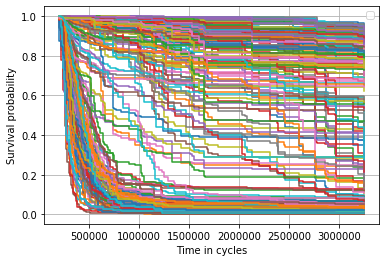

In [56]:
surv = rsf.predict_survival_function(X_test, return_array=False)

for fn in surv:
    plt.step(fn.x, fn(fn.x), where="post")
plt.ylabel("Survival probability")
plt.xlabel("Time in cycles")
plt.legend()
plt.grid(True)

In [57]:
print(surv.shape)
print(X_test.shape)

(250,)
(250, 13)


No handles with labels found to put in legend.


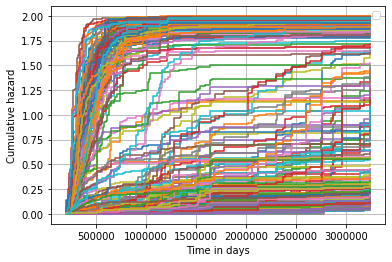

In [58]:
surv = rsf.predict_cumulative_hazard_function(X_test, return_array=False)

for fn in surv:
    plt.step(fn.x, fn(fn.x), where="post")
plt.ylabel("Cumulative hazard")
plt.xlabel("Time in days")
plt.legend()
plt.grid(True)

## Test on the real data

Calculate the concordance index. The model doesn't perform very well for the real data.

In [59]:
data_real = pd.read_csv(os.path.join(os.path.dirname(os.getcwd()), '../Data/Merged_data/Survival_df.csv'),
                  index_col=0)

real_x = data_real.iloc[:, 2:]
real_y = data_real.iloc[:, 0:2]
real_y_num = real_y.to_records(index=False)

rsf.score(real_x,real_y_num)

0.6976744186046512

## Feature importance by permutation

This estimates the importance of each feature by permutating it and looking at the effect on the model. This is not good when the features are correlated as they are in this case. We test on a subset of the features.

In [14]:
data_x = data.iloc[:, 2:]
data_y = data.iloc[:, 0:2]
df_features = data_x[mc.feature_selection]

X_train, X_test, y_train, y_test = train_test_split(
    df_features, data_y, test_size=0.25)
y_train_num = y_train.to_records(index=False)
y_test_num = y_test.to_records(index=False)


In [15]:

rsf = RandomSurvivalForest(n_estimators=1000,
                           max_features="auto",
                          oob_score=True
                          )
rsf.fit(X_train, y_train_num)
rsf.oob_score_

0.869709444481937

In [16]:
y_pred = pd.Series(rsf.predict(X_test))
rsf.score(X_test,y_test_num)

0.866278243569703

In [17]:
perm = PermutationImportance(rsf, n_iter=15)
perm.fit(X_test, y_test_num)

PermutationImportance(cv='prefit',
                      estimator=RandomSurvivalForest(bootstrap=True,
                                                     max_depth=None,
                                                     max_features='auto',
                                                     max_leaf_nodes=None,
                                                     max_samples=None,
                                                     min_samples_leaf=3,
                                                     min_samples_split=6,
                                                     min_weight_fraction_leaf=0.0,
                                                     n_estimators=1000,
                                                     n_jobs=None,
                                                     oob_score=True,
                                                     random_state=None,
                                                     verbose=0,
                                   

In [18]:
feature_names = X_test.columns.tolist()
eli5.show_weights(perm, feature_names=feature_names)

Weight,Feature
0.1947 ± 0.0363,NDE_cyle
0.0418 ± 0.0126,amp_ratio
0.0224 ± 0.0138,NLO_avg
0.0203 ± 0.0127,pos_ratio
0.0181 ± 0.0138,NLE_ratio_85_17


Calculate the concordance index and important features with a subset of features that without number of cycles.

In [19]:
data_x = data.iloc[:, 2:]
data_y = data.iloc[:, 0:2]
df_features = data_x[mc.feature_selection2]

X_train, X_test, y_train, y_test = train_test_split(
    df_features, data_y, test_size=0.25)
y_train_num = y_train.to_records(index=False)
y_test_num = y_test.to_records(index=False)


In [20]:

rsf = RandomSurvivalForest(n_estimators=1000,
                           max_features="auto",
                          oob_score=True
                          )
rsf.fit(X_train, y_train_num)
rsf.oob_score_

0.8684779782642609

In [21]:
y_pred = pd.Series(rsf.predict(X_test))
rsf.score(X_test,y_test_num)

0.8575600565237871

In [22]:
perm = PermutationImportance(rsf, n_iter=15)
perm.fit(X_test, y_test_num)

PermutationImportance(cv='prefit',
                      estimator=RandomSurvivalForest(bootstrap=True,
                                                     max_depth=None,
                                                     max_features='auto',
                                                     max_leaf_nodes=None,
                                                     max_samples=None,
                                                     min_samples_leaf=3,
                                                     min_samples_split=6,
                                                     min_weight_fraction_leaf=0.0,
                                                     n_estimators=1000,
                                                     n_jobs=None,
                                                     oob_score=True,
                                                     random_state=None,
                                                     verbose=0,
                                   

In [23]:
feature_names = X_test.columns.tolist()
eli5.show_weights(perm, feature_names=feature_names)

Weight,Feature
0.1347 ± 0.0277,Avg_RP
0.0911 ± 0.0258,NLE_ratio_85_17
0.0402 ± 0.0145,amp_ratio
0.0211 ± 0.0135,pos_ratio
0.0175 ± 0.0101,NLO_avg


Calculate concordance and feature importance with only NLO for comparison.

In [24]:
data_x = data.iloc[:, 2:]
data_y = data.iloc[:, 0:2]
df_features = pd.DataFrame(data_x['NLO_avg'])

X_train, X_test, y_train, y_test = train_test_split(
    df_features, data_y, test_size=0.25)
y_train_num = y_train.to_records(index=False)
y_test_num = y_test.to_records(index=False)

rsf = RandomSurvivalForest(n_estimators=1000,
                           max_features="auto",
                          oob_score=True
                          )
rsf.fit(X_train, y_train_num)
print(rsf.oob_score_)

y_pred = pd.Series(rsf.predict(X_test))
print(rsf.score(X_test,y_test_num))

perm = PermutationImportance(rsf, n_iter=15)
perm.fit(X_test, y_test_num)

feature_names = X_test.columns.tolist()
eli5.show_weights(perm, feature_names=feature_names)

0.6911343891075505
0.7326130992572586


Weight,Feature
0.2363 ± 0.0528,NLO_avg
